From [the RLRF paper](https://arxiv.org/pdf/2505.20793)
> We preprocess this data by rounding decimals to two
significant figures, removing XML headers, and filtering out samples with excessively long URLs or
embedded base64 images, which could lead the model to memorize irrelevant content

In [1]:
import platform
import os

# Workaround for datasets multiprocessing crashing on macOS
if platform.system() == "Darwin":
    print(
        f"Fork safety disabled: {os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY']}"
    )
    # os.environ["OBJC_DISABLE_INITIALIZE_FORK_SAFETY"] = "YES"

Fork safety disabled: YES


In [2]:
from datasets import load_dataset, Dataset

dataset = load_dataset("starvector/svg-stack", split="train")
dataset

Dataset({
    features: ['Filename', 'Svg'],
    num_rows: 2169710
})

In [3]:
dataset[1230]

{'Filename': '0bf622d38312a560d831a6005ff2c326f7e7771d.svg',
 'Svg': '<svg role="img" viewBox="0 0 24 24" xmlns="http://www.w3.org/2000/svg"><path d="M10.040 0.041 C 6.371 0.422,3.109 2.637,1.500 5.840 C 0.240 8.348,0.055 11.425,1.007 14.060 C 2.191 17.338,5.083 19.881,8.580 20.719 C 9.519 20.944,9.850 20.980,10.980 20.980 C 12.084 20.980,12.503 20.937,13.327 20.744 L 13.714 20.653 13.944 21.025 C 15.161 22.991,16.605 23.910,18.600 23.988 C 20.479 24.061,21.924 23.365,22.806 21.961 C 23.276 21.212,23.600 20.091,23.600 19.211 L 23.600 19.000 22.821 19.000 L 22.042 19.000 22.018 19.110 C 21.925 19.547,21.677 20.009,21.410 20.244 C 20.810 20.770,19.746 20.760,18.954 20.219 C 18.632 19.999,18.210 19.563,17.859 19.088 L 17.602 18.740 17.751 18.620 C 19.502 17.209,20.737 15.306,21.281 13.180 C 21.542 12.159,21.580 11.817,21.579 10.500 C 21.578 9.482,21.567 9.277,21.488 8.824 C 21.314 7.824,21.063 6.989,20.685 6.160 C 19.206 2.912,16.117 0.642,12.432 0.098 C 11.940 0.025,10.517 -0.009,10.040 

Rasterized SVG with implicit size 24.0x24.0px to image dimensions: (128, 128)


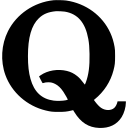

In [4]:
from PIL import Image
import os
import io
# stupid cairo
os.environ["DYLD_LIBRARY_PATH"] = "/opt/homebrew/lib:" + os.environ.get("DYLD_LIBRARY_PATH", "")

from svg_rlrf_reward import rasterize_svg

image_bytes, tree, (width, height) = rasterize_svg(dataset[1230]["Svg"], min_target=128, max_target=512)
image = Image.open(io.BytesIO(image_bytes))
print(f"Rasterized SVG with implicit size {width}x{height}px to image dimensions: {image.size}")
image

In [7]:
split_dataset = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = split_dataset["train"]
test_dataset = split_dataset["test"]

print(f"Train size: {len(train_dataset)}")
print(f"Test size: {len(test_dataset)}")

def rasterize(example):
    try:
        img_bytes, tree, (width, height) = rasterize_svg(example["Svg"], min_target=512, max_target=1536)
        # todo: use tree to enrich metadata
        return {"image": Image.open(io.BytesIO(img_bytes)), "width": width, "height": height}
    except Exception:
        return {"image": None, "width": None, "height": None}

subset = dataset.select(range(1000))

subset = subset.map(
    rasterize,
    num_proc=os.cpu_count() or 4,
)

Train size: 1952739
Test size: 216971


Map (num_proc=8):   0%|          | 0/1000 [00:00<?, ? examples/s]

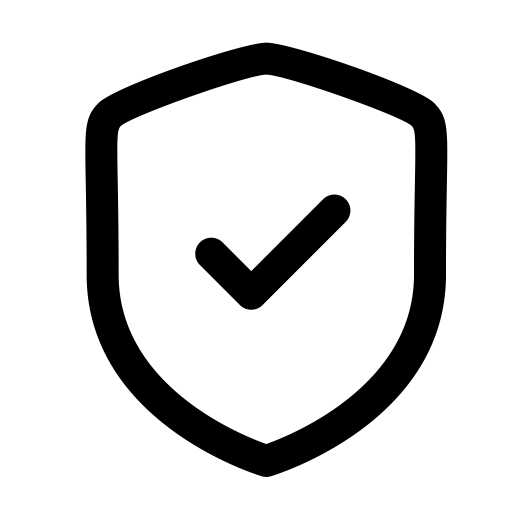

In [8]:
subset["image"][123]


In [9]:
subset = subset.filter(lambda x: x["image"] is not None)
print(f"{len(subset)}/{1000} images rendered successfully")
subset

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

775/1000 images rendered successfully


Dataset({
    features: ['Filename', 'Svg', 'image', 'width', 'height'],
    num_rows: 775
})

In [10]:
import subprocess
import tempfile
import os

from datasets import Value

def svgo_batch(svg_texts, precision: int = 2, pretty: bool = False):
    """
    Optimize a batch of SVGs by writing them to a temp directory and running svgo on the directory.
    Returns a list of optimized SVG strings in the same order.
    If the batch fails, runs on individual files so that only the bad files are excluded.
    Uses the same input/output directories for individual files.
    """
    def filename(i: int) -> str:
        return f"{i:06d}.svg"

    svgo_args = ["--precision", str(precision)]
    if pretty:
        svgo_args.append("--pretty")

    with tempfile.TemporaryDirectory() as tmpdir:
        input_dir = os.path.join(tmpdir, "input")
        output_dir = os.path.join(tmpdir, "output")
        os.makedirs(input_dir, exist_ok=True)
        os.makedirs(output_dir, exist_ok=True)
        # Write each SVG to a file in the input directory
        for i, svg in enumerate(svg_texts):
            fname = filename(i)
            with open(os.path.join(input_dir, fname), "w", encoding="utf-8") as f:
                f.write(svg)
        # Run svgo on the directory

        cmd = [
            "npx", "-y", "svgo",
            "-f", input_dir,
            "-o", output_dir,
            *svgo_args,
        ]
        proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        optimized_svgs = []
        batch_failed = proc.returncode != 0
        if batch_failed:
            print(f"SVGO on batch failed: {proc.stderr.decode('utf-8')}, included files: {[os.path.join(input_dir, x) for x in os.listdir(input_dir)]}")
            # Try to optimize each SVG individually, reusing the same input/output dirs
            for i, svg in enumerate(svg_texts):
                fname = filename(i)
                input_path = os.path.join(input_dir, fname)
                output_path = os.path.join(output_dir, fname)
                single_cmd = [
                    "npx", "-y", "svgo",
                    "-i", input_path,
                    "-o", output_path,
                    *svgo_args,
                ]
                single_proc = subprocess.run(single_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
                if single_proc.returncode != 0 or not os.path.exists(output_path):
                    print(
                        f"SVGO failed on single file {input_path}\n\n{svg_texts[i]}\n\n{single_proc.stderr.decode('utf-8')}"
                    )
                    optimized_svgs.append(svg)
                else:
                    with open(output_path, "r", encoding="utf-8") as f:
                        optimized_svgs.append(f.read())
        else:
            # Read optimized SVGs in the same order using out_fnames
            for i in range(len(svg_texts)):
                out_path = os.path.join(output_dir, filename(i))
                if not os.path.exists(out_path):
                    print(f"SVGO failed on {out_path}")
                    # If svgo failed to write output, fallback to original
                    optimized_svgs.append(svg_texts[i])
                else:
                    with open(out_path, "r", encoding="utf-8") as f:
                        optimized_svgs.append(f.read())
        return optimized_svgs

original_svg = dataset[1230]["Svg"]
optimized_svg = svgo_batch([original_svg])[0]
print(f"Saved {len(original_svg) - len(optimized_svg)} bytes ({((len(original_svg) - len(optimized_svg)) / len(original_svg) * 100):.2f}%) by optimizing")

def svg_optim_batched(batch, **kwargs):
    optimized_svgs = svgo_batch(batch["Svg"], **kwargs)
    metas = []
    for original_svg, optimized_svg in zip(batch["Svg"], optimized_svgs):
        metas.append({
            "original_size": len(original_svg),
            "optimized_size": len(optimized_svg),
            "bytes_saved": len(original_svg) - len(optimized_svg),
            "percent_saved": ((len(original_svg) - len(optimized_svg)) / len(original_svg) * 100) if len(original_svg) > 0 else 0
        })
    return {"Svg": optimized_svgs, "meta": metas}

features = subset.features.copy()
features["meta"] = {
    "original_size": Value("int32"),
    "optimized_size": Value("int32"),
    "bytes_saved": Value("int32"),
    "percent_saved": Value("float32"),
}

# Use batch mapping for speed, now using file-based batch optimization
subset_opt = subset.map(
    svg_optim_batched,
    batched=True,
    batch_size=16,
    features=features,
    num_proc=8,
)
subset_opt


Saved 916 bytes (48.59%) by optimizing


Map (num_proc=8):   0%|          | 0/775 [00:00<?, ? examples/s]

Dataset({
    features: ['Filename', 'Svg', 'image', 'width', 'height', 'meta'],
    num_rows: 775
})

In [11]:
subset_opt[0]["meta"]

{'original_size': 1165,
 'optimized_size': 419,
 'bytes_saved': 746,
 'percent_saved': 64.03433227539062}

Filter:   0%|          | 0/775 [00:00<?, ? examples/s]

770/775 images are free of base64 images
Examples with base64 images (showing up to 5):
----------------------------------------------------------------------------------------------------
Filename: eeb61ae6c3e61554d6b2808412dff90704f4ca10.svg
SVG: <svg xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink" width="103" height="69.03"><defs><filter id="a" width="56.03" height="36.5" x="401.97" y="409.97" filterUnits="userSpaceOnUse"><feImage xlink:href="" width="56.03" height="36.5" x="401.97" y="409.97" preserveAspectRatio="none" result="image"/><feComposite in2="SourceGraphic" operator="in" result="composite"/><feBlend in2="SourceGraphic" mode="overlay" result="blend"/></filter><filter id="b" width="92" height="68" x="355" y="411" filterUnits="userSpaceOnUse"><feOffset dy="5" in="SourceAlpha" result="offset"/><feGaussianBlur result="blur" stdDeviation="3.16"/><feFlood flood-opacity=".15" result="flood"/><feComposite in2="blur" operator="in" result="composite"/><
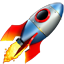
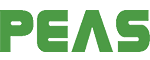
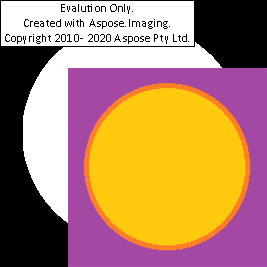

In [12]:
import re

def no_base64_image(example):
    svg = example.get("Svg", "")
    # Look for <image ... xlink:href="data:image/..." or href="data:image/..."
    return not re.search(r'(xlink:href|href)\s*=\s*["\']data:image\/', svg)

subset_no_base64 = subset_opt.filter(no_base64_image)
subset_no_base64

print(f"{len(subset_no_base64)}/{len(subset_opt)} images are free of base64 images")

# Print some examples that fail the check
failed_examples = [ex for ex in subset_opt if not no_base64_image(ex)]
print("Examples with base64 images (showing up to 5):")
for ex in failed_examples[:5]:
    print("-"*100)
    print(f"Filename: {ex.get('Filename', 'N/A')}")
    print(f"SVG: {ex.get('Svg', '')}\n")

In [13]:
# filter out any images that are a solid color

def not_solid_color(example):
    extrema = example['image'].getextrema()
    if isinstance(extrema[0], tuple):
        return any(lo != hi for lo, hi in extrema)
    else:
        return extrema[0] != extrema[1]

subset_not_solid_color = subset_opt.filter(not_solid_color)
subset_not_solid_color

# Print some examples that fail the check
failed_examples = [ex for ex in subset_opt if not not_solid_color(ex)]
print(f"{len(failed_examples)}/{len(subset_opt)} images were solid-color")
for ex in failed_examples:
    print("-"*100, "\n", ex.get('Filename', 'N/A'), "\n", ex.get('Svg', ''), "\n")



Filter:   0%|          | 0/775 [00:00<?, ? examples/s]

0/775 images were solid-color


In [14]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct", fast=True)

def add_token_counts(ex: dict[str, list[any]]):
    svgs_tokenized = tokenizer(ex["Svg"], padding=False, truncation=False)["input_ids"]
    return {"svg_token_count": [len(t) for t in svgs_tokenized]}

subset_opt_tk = subset_opt.map(add_token_counts, batched=True, batch_size=256)

min_tokens = 100
subset_gt_thresh = subset_opt_tk.filter(lambda ex: ex["svg_token_count"] >= min_tokens)
subset_gt_thresh

# Print some examples that failed the check
failed = subset_opt_tk.filter(lambda ex: ex["svg_token_count"] <= min_tokens)
print(f"{len(failed)}/{len(subset_opt_tk)} examples have less than {min_tokens} tokens")
for ex in failed:
    print("-" * 100, "\n", f"{ex['Filename']}: {ex['svg_token_count']} tokens\n", ex.get("Svg", ""), "\n")


Map:   0%|          | 0/775 [00:00<?, ? examples/s]

Filter:   0%|          | 0/775 [00:00<?, ? examples/s]

Filter:   0%|          | 0/775 [00:00<?, ? examples/s]

26/775 examples have less than 100 tokens
---------------------------------------------------------------------------------------------------- 
 32c49e5595f87ef49f2c17d89b56541a6308ad22.svg: 78 tokens
 <svg xmlns="http://www.w3.org/2000/svg" fill="currentColor" viewBox="0 0 32 32"><path d="M9 18h16a1 1 0 0 0 0-2H9a1 1 0 0 0 0 2z"/></svg> 

---------------------------------------------------------------------------------------------------- 
 98b70477c601d03a0ec1783a79a3e942bc335397.svg: 98 tokens
 <svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 32 32"><path d="M2 4h4V2a2 2 0 0 1 4 0v2h12V2a2 2 0 0 1 4 0v2h4v6H2m0 2h28v18H2"/></svg> 

---------------------------------------------------------------------------------------------------- 
 e6057caf6636630707582c49133e67d54de96241.svg: 65 tokens
 <svg xmlns="http://www.w3.org/2000/svg" width="100" height="80"><text x="50" y="40" style="font-size:76px;dominant-baseline:central;text-anchor:middle">悲</text></svg> 

-------------------------

In [15]:
def filter_svgs_with_text(example):
    return not re.search(r'<text', example["Svg"])

subset_no_text = subset_opt.filter(filter_svgs_with_text)
subset_no_text

# Print some examples that failed the check
failed_text = subset_opt.filter(lambda ex: re.search(r"<text", ex["Svg"]))
print(f"{len(failed_text)}/{len(subset_gt_thresh)} examples contain <text> elements")
for ex in failed_text:
    print("-" * 100, "\n", f"{ex['Filename']}\n", ex.get("Svg", ""), "\n")

Filter:   0%|          | 0/775 [00:00<?, ? examples/s]

Filter:   0%|          | 0/775 [00:00<?, ? examples/s]

43/750 examples contain <text> elements
---------------------------------------------------------------------------------------------------- 
 26256bdf7e3e71a02c7ced60963f2d2b1cab56e4.svg
 <svg xmlns="http://www.w3.org/2000/svg" width="420" height="320"><defs><clipPath id="a"><path d="M5.5 135.5h410v178H5.5zm402 10v158h-394v-158h394zm2-2h-398v162h398v-162z"/></clipPath><clipPath id="c"><path d="M4.5 3.5h410v78H4.5zm402 10v58h-394v-58h394zm2-2h-398v62h398v-62z"/></clipPath><filter id="b"><feGaussianBlur in="SourceAlpha" stdDeviation="2.5"/><feOffset dy="2" result="offsetblur"/><feFlood flood-color="#000"/><feComposite in2="offsetblur" operator="in"/></filter><filter id="d"><feGaussianBlur in="SourceAlpha" stdDeviation="2.5"/><feOffset dy="2" result="offsetblur"/><feFlood flood-color="#000"/><feComposite in2="offsetblur" operator="in"/></filter></defs><path fill="rgba(0,0,0,0.75)" d="M409.5 143.5v162h-398v-162h398zm-2 2h-394v158h394v-158z" clip-path="url(#a)" filter="url(#b)"/><path fill

In [16]:
# Run all filters in sequence

def run_all_processing(subset: Dataset, min_tokens: int = 100):
    num_proc = os.cpu_count() or 4
    # 1. Remove solid-color images
    filtered = (
        subset.map(rasterize, num_proc=num_proc)
        .map(
            svg_optim_batched,
            batched=True,
            batch_size=16,
            features=features,
            num_proc=num_proc,
        )
        .filter(lambda ex: ex["image"] is not None)
        .filter(not_solid_color, num_proc=num_proc)
        .map(add_token_counts, batched=True, batch_size=256)
        .filter(lambda ex: ex["svg_token_count"] >= min_tokens, num_proc=num_proc)
        .filter(filter_svgs_with_text, num_proc=num_proc)
    )
    return filtered

train = run_all_processing(dataset.select(range(100_000)))
train

dataset_val = load_dataset("starvector/svg-stack", split="val")
val = run_all_processing(dataset_val.map(rasterize, with_indices=False))


Map (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

SVGO on batch failed: SvgoParserError: /var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000003.svg:1:919: Unclosed root tag

> 1 | …938.687-.062.125-.125.25-.156.375v-1.078zm0 0"/></svg>
    |                                                       ^

, included files: ['/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000009.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000008.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000003.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000002.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000000.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000014.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000015.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/input/000001.svg', '/var/folders/5r/np8nyb993_z6v7bj_5910qn80000gn/T/tmpixtmutom/inp

TimeoutError: 

In [ ]:
from datasets import concatenate_datasets

# Merge train and val datasets
full_dataset = concatenate_datasets([train, val])

# Push to the Hugging Face Hub (private)
full_dataset.push_to_hub("darknoon/svg-stack-filtered", private=True)


Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/49623 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/497 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/400M [00:00<?, ?B/s]

Map:   0%|          | 0/49623 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/497 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/403M [00:00<?, ?B/s]

Map:   0%|          | 0/49623 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/497 [00:00<?, ?ba/s]

Uploading...:   0%|          | 0.00/412M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/darknoon/svg-stack-filtered/commit/28587f417381d0f422ef73f53da654e8523e6216', commit_message='Upload dataset', commit_description='', oid='28587f417381d0f422ef73f53da654e8523e6216', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/darknoon/svg-stack-filtered', endpoint='https://huggingface.co', repo_type='dataset', repo_id='darknoon/svg-stack-filtered'), pr_revision=None, pr_num=None)